taken from https://render.githubusercontent.com/view/ipynb?commit=e6044bfb5a30247c75aeb81dfad3a8b918c6f4b7&enc_url=68747470733a2f2f7261772e67697468756275736572636f6e74656e742e636f6d2f6b7261737365726d2f626179657369616e2d6d616368696e652d6c6561726e696e672f653630343462666235613330323437633735616562383164666164336138623931386336663462372f626179657369616e5f6f7074696d697a6174696f6e2e6970796e62&nwo=krasserm%2Fbayesian-machine-learning&path=bayesian_optimization.ipynb&repository_id=125869131&repository_type=Repository#Application


In [3]:
import numpy as np

%matplotlib inline

bounds = np.array([[-1.0, 2.0]])
noise = 0.2

def f(X, noise=noise):
    return -np.sin(3*X) - X**2 + 0.7*X + noise * np.random.randn(*X.shape)

X_init = np.array([[-0.9], [1.1]])
Y_init = f(X_init)

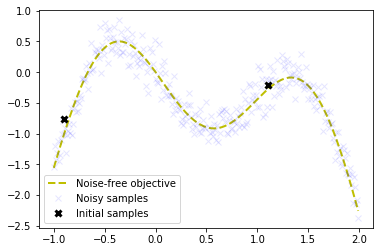

In [4]:
import matplotlib.pyplot as plt

# Dense grid of points within bounds
X = np.arange(bounds[:, 0], bounds[:, 1], 0.01).reshape(-1, 1)

# Noise-free objective function values at X 
Y = f(X,0)

# Plot optimization objective with noise level 
plt.plot(X, Y, 'y--', lw=2, label='Noise-free objective')
plt.plot(X, f(X), 'bx', lw=1, alpha=0.1, label='Noisy samples')
plt.plot(X_init, Y_init, 'kx', mew=3, label='Initial samples')
plt.legend();

ValueError: shape mismatch: value array of shape (200,1,1) could not be broadcast to indexing result of shape (1,200)

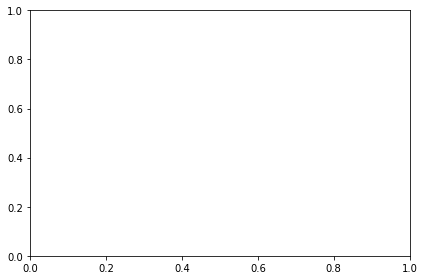

In [5]:
import GPy
import GPyOpt

from GPyOpt.methods import BayesianOptimization

kernel = GPy.kern.Matern52(input_dim=1, variance=1.0, lengthscale=1.0)
bds = [{'name': 'X', 'type': 'continuous', 'domain': bounds.ravel()}]

optimizer = BayesianOptimization(f=f, 
                                 domain=bds,
                                 model_type='GP',
                                 kernel=kernel,
                                 acquisition_type ='EI',
                                 acquisition_jitter = 0.01,
                                 X=X_init,
                                 Y=-Y_init,
                                 noise_var = noise**2,
                                 exact_feval=False,
                                 normalize_Y=False,
                                 maximize=True)

optimizer.run_optimization(max_iter=10)
optimizer.plot_acquisition()

In [6]:
from sklearn import datasets
from sklearn.model_selection import RandomizedSearchCV, cross_val_score

from scipy.stats import uniform
from xgboost import XGBRegressor

# Load the diabetes dataset (for regression)
X, Y = datasets.load_diabetes(return_X_y=True)

# Instantiate an XGBRegressor with default hyperparameter settings
xgb = XGBRegressor()

# and compute a baseline to beat with hyperparameter optimization 
baseline = cross_val_score(xgb, X, Y, scoring='neg_mean_squared_error').mean()

### Hyperparameter tuning with random search
For hyperparameter tuning with random search, we use RandomSearchCV of scikit-learn and compute a cross-validation score for each randomly selected point in hyperparameter space. Results will be discussed below.

In [32]:
# Hyperparameters to tune and their ranges
param_dist = {"learning_rate": uniform(0, 1),
              "gamma": uniform(0, 5),
              "max_depth": range(1,50),
              "n_estimators": range(1,500),
              "min_child_weight": range(1,10)}

rs = RandomizedSearchCV(xgb, param_distributions=param_dist, 
                        scoring='neg_mean_squared_error', n_iter=25)

# Run random search for 25 iterations
rs.fit(X, Y);

 /home/jzornig/.conda/envs/dscmsc/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning:The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.


### Hyperparameter tuning with Bayesian optimization
To tune hyperparameters with Bayesian optimization we implement an objective function cv_score that takes hyperparameters as input and returns a cross-validation score. Here, we assume that cross-validation at a given point in hyperparameter space is deterministic and therefore set the exact_feval parameter of BayesianOptimization to True. Depending on model fitting and cross-validation details this might not be the case but we ignore that here.

In [27]:
bds = [{'name': 'learning_rate', 'type': 'continuous', 'domain': (0, 1)},
        {'name': 'gamma', 'type': 'continuous', 'domain': (0, 5)},
        {'name': 'max_depth', 'type': 'discrete', 'domain': (1, 50)},
        {'name': 'n_estimators', 'type': 'discrete', 'domain': (1, 500)},
        {'name': 'min_child_weight', 'type': 'discrete', 'domain': (1, 10)}]

# Optimization objective 
def cv_score(parameters):
    parameters = parameters[0]
    score = cross_val_score(
                XGBRegressor(learning_rate=parameters[0],
                              gamma=int(parameters[1]),
                              max_depth=int(parameters[2]),
                              n_estimators=int(parameters[3]),
                              min_child_weight = parameters[4]), 
                X, Y, scoring='neg_mean_squared_error').mean()
    score = np.array(score)
    return score

optimizer = BayesianOptimization(f=cv_score, 
                                 domain=bds,
                                 model_type='GP',
                                 acquisition_type ='EI',
                                 acquisition_jitter = 0.05,
                                 exact_feval=True, 
                                 maximize=True)

# Only 20 iterations because we have 5 initial random points
optimizer.run_optimization(max_iter=20)

Baseline neg. MSE = -3498.95
Random search neg. MSE = -3758.62
Bayesian optimization neg. MSE = -3253.51


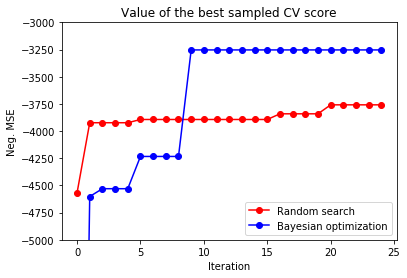

In [33]:
y_rs = np.maximum.accumulate(rs.cv_results_['mean_test_score'])
y_bo = np.maximum.accumulate(-optimizer.Y).ravel()

print(f'Baseline neg. MSE = {baseline:.2f}')
print(f'Random search neg. MSE = {y_rs[-1]:.2f}')
print(f'Bayesian optimization neg. MSE = {y_bo[-1]:.2f}')

plt.plot(y_rs, 'ro-', label='Random search')
plt.plot(y_bo, 'bo-', label='Bayesian optimization')
plt.xlabel('Iteration')
plt.ylabel('Neg. MSE')
plt.ylim(-5000, -3000)
plt.title('Value of the best sampled CV score');
plt.legend();

In [29]:
y_rs


array([-5636.80819225, -4059.83944712, -3667.2039226 , -3667.2039226 ,
       -3667.2039226 , -3667.2039226 , -3667.2039226 , -3667.2039226 ,
       -3667.2039226 , -3667.2039226 , -3667.2039226 , -3667.2039226 ,
       -3667.2039226 , -3667.2039226 , -3667.2039226 , -3667.2039226 ,
       -3667.2039226 , -3667.2039226 , -3667.2039226 , -3667.2039226 ,
       -3667.2039226 , -3667.2039226 , -3667.2039226 , -3667.2039226 ,
       -3667.2039226 ])

In [30]:
y_bo

array([-11943.18686118,  -4602.03504775,  -4530.02226126,  -4530.02226126,
        -4530.02226126,  -4233.34353954,  -4233.34353954,  -4233.34353954,
        -4233.34353954,  -3253.50550046,  -3253.50550046,  -3253.50550046,
        -3253.50550046,  -3253.50550046,  -3253.50550046,  -3253.50550046,
        -3253.50550046,  -3253.50550046,  -3253.50550046,  -3253.50550046,
        -3253.50550046,  -3253.50550046,  -3253.50550046,  -3253.50550046,
        -3253.50550046])

In [31]:
x_best = optimizer.x_opt #myBopt.X[np.argmin(myBopt.Y)]
print(x_best)

[8.63027567e-03 3.69290051e+00 1.00000000e+00 5.00000000e+02
 1.00000000e+01]
